XGBoost Code for running binary classificaiton of patient data
https://xgboost.readthedocs.io/en/latest/parameter.html - Link to the parameter definitions
Grid searching can be applied to optimize the parameter tuning if desired.

In [56]:
import xgboost as xgb
import pandas as pd
import numpy as np
import sklearn
import matplotlib
from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib
from sklearn.metrics import precision_score

In [6]:
datafile = open('testdata.txt', 'r')
data = pd.read_csv(datafile, sep = "\t")

The code below changes categorical variables to numeric.  It does NOT do one hot encoding.  It only replaces the values with a number corresponding to the different number of entities in the column.  One hot encoding is an option that could be used instead.

In [7]:
for feature in data.columns: # Loop through all columns in the dataframe
    if data[feature].dtype == 'object': # Only apply for columns with categorical strings
        data[feature] = pd.Categorical(data[feature]).codes # Replace strings with an integer

Split the data into data frames of variables(X) and target (y).  The term "Season" must be changed to accomodate the prediction target name.

In [8]:
X = data.drop("Season", axis=1)
y = data["Season"]

Train/test splits of the data, 80/20 split.  The test_size can be changed to any value.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Creat the necessary xgboost matrices for the algorithm.

In [57]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

Model parameter settings.  Included below are the most commonly changed settings and the default settings.  The website above has explanations of each and defaluts.

In [37]:
param = {'max_depth': 1, 'eta': 0.9, 'gamma':0, 
         'silent': 1, 'min_child_weight':1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'

Set the number of folds for the cross validation run to find optimal number of rounds for the xgboost algorithm to run.

In [38]:
n_folds = 10
early_stopping = 10

Run a cross validation to find the optimal number of nrounds for the final model. 

In [39]:
cv = xgb.cv(param, dtrain, 5000, nfold=n_folds, early_stopping_rounds=early_stopping, verbose_eval=1)

[0]	train-auc:0.734608+0.000898196	test-auc:0.734501+0.00805576
[1]	train-auc:0.822222+0.000790204	test-auc:0.82212+0.00697276
[2]	train-auc:0.93867+0.000525561	test-auc:0.938624+0.00474451
[3]	train-auc:1+0	test-auc:1+0
[4]	train-auc:1+0	test-auc:1+0
[5]	train-auc:1+0	test-auc:1+0
[6]	train-auc:1+0	test-auc:1+0
[7]	train-auc:1+0	test-auc:1+0
[8]	train-auc:1+0	test-auc:1+0
[9]	train-auc:1+0	test-auc:1+0
[10]	train-auc:1+0	test-auc:1+0
[11]	train-auc:1+0	test-auc:1+0
[12]	train-auc:1+0	test-auc:1+0


In [40]:
cv

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.734608,0.000898,0.734501,0.008056
1,0.822222,0.000790,0.822120,0.006973
2,0.938670,0.000526,0.938624,0.004745
3,1.000000,0.000000,1.000000,0.000000


In [41]:
evallist = [(dtest, 'eval'), (dtrain, 'train')]

Use the optimal found in the cross validation for the num_rounds

In [50]:
num_round = 3
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-auc:0.734143	train-auc:0.734609
[1]	eval-auc:0.81802	train-auc:0.822224
[2]	eval-auc:0.935375	train-auc:0.93867


Predict the test set

In [51]:
ypred = bst.predict(dtest)

In [52]:
ypred

array([0.8443916 , 0.07787831, 0.8443916 , ..., 0.449635  , 0.449635  ,
       0.449635  ], dtype=float32)

Variable importance plot

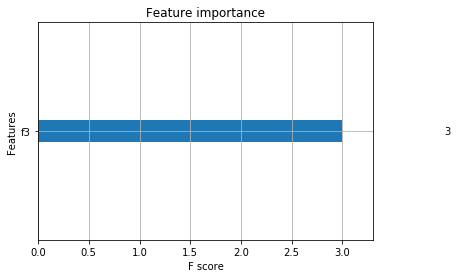

In [53]:
xgb.plot_importance(bst)